In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [10]:
vctabgan_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/vae-ctabgan.csv"
vctabgan = pd.read_csv(vctabgan_path)

vctabgan['return'] = (vctabgan['total_pymnt_inv']-vctabgan['funded_amnt'])/vctabgan['funded_amnt']

In [11]:
original_df = pd.read_csv("C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category_1.csv", low_memory=False)

In [5]:
vctabgan.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status', 'return'],
      dtype='object')

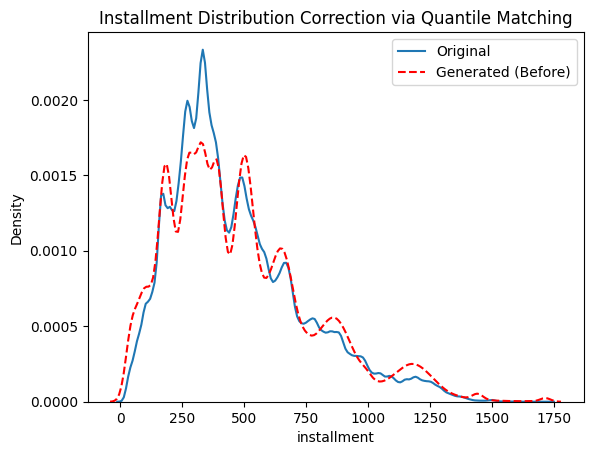

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(original_df['installment'], label='Original', bw_adjust=0.5)
sns.kdeplot(vctabgan['installment'], label='Generated (Before)', color='red', linestyle='--')
#sns.kdeplot(vctabgan['installment_adj'], label='Generated (After)', color='green')
plt.legend()
plt.title("Installment Distribution Correction via Quantile Matching")
plt.show()


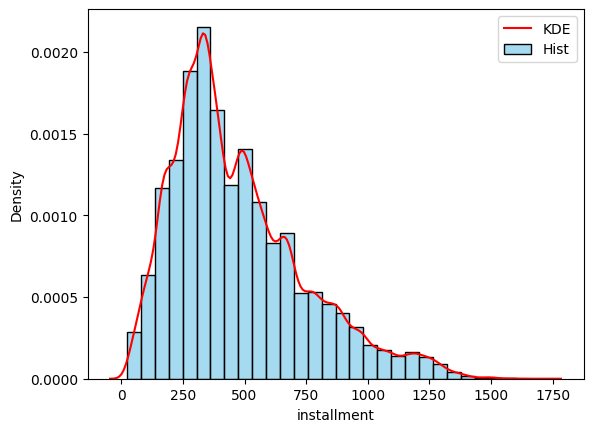

In [8]:
sns.histplot(data=original_df['installment'], bins=30, stat='density', label='Hist', color='skyblue')
sns.kdeplot(data=original_df['installment'], label='KDE', color='red')
plt.legend()

In [12]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform', n_quantiles=1000)
qt.fit(original_df[['installment']])  # 원본 데이터 기준

# 합성 데이터 보정
vctabgan['installment'] = qt.inverse_transform(
    QuantileTransformer().fit_transform(vctabgan[['installment']])
)

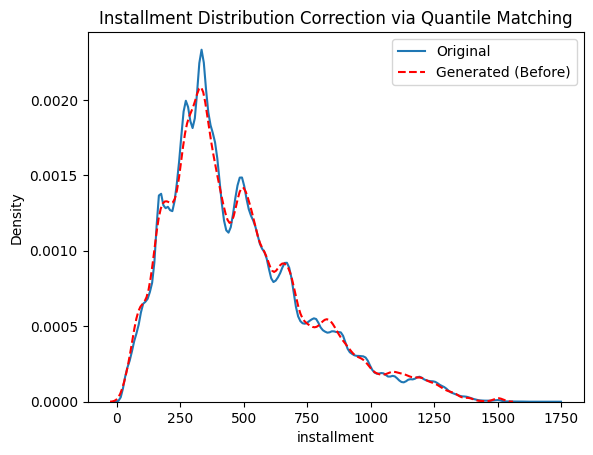

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(original_df['installment'], label='Original', bw_adjust=0.5)
sns.kdeplot(vctabgan['installment'], label='Generated (Before)', color='red', linestyle='--')
#sns.kdeplot(vctabgan['installment_adj'], label='Generated (After)', color='green')
plt.legend()
plt.title("Installment Distribution Correction via Quantile Matching")
plt.show()


In [7]:
threshold = 1.17

vctabgan_outliers = vctabgan[vctabgan['return'] > threshold]

len(vctabgan_outliers)

16682

In [8]:
vctabgan_outliers_sorted = vctabgan_outliers.sort_values(by='return', ascending=False)
print(vctabgan_outliers_sorted[['installment','total_pymnt_inv', 'funded_amnt', 'return']].head())

        installment  total_pymnt_inv  funded_amnt     return
264445   149.402953         61947.53       1000.0  60.947530
346203   117.374884         61947.53       1100.0  55.315936
394992   381.356129         55606.01       1000.0  54.606010
455288    96.216729         50929.34       1000.0  49.929340
537440   350.785755         50218.12       1000.0  49.218120


In [9]:
import pandas as pd

# 0. 원본 데이터 로드
#original_df = pd.read_csv("C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category_1.csv", low_memory=False)

# 금액 관련 컬럼 숫자형 변환
for col in ['funded_amnt', 'loan_amnt', 'total_pymnt', 'total_pymnt_inv']:
    original_df[col] = pd.to_numeric(original_df[col], errors='coerce')

# 1. 이상치 추출
threshold = 1.17
vctabgan_outliers = vctabgan[vctabgan['return'] > threshold].copy()

# 2. 대체할 컬럼
cols_to_replace = ['total_pymnt_inv', 'total_pymnt', 'loan_amnt']

# 3. funded_amnt 기준 가장 가까운 원본 값으로부터 3개 컬럼 추출
def find_realistic_values(row):
    f_target = row['funded_amnt']
    
    candidates = original_df.dropna(subset=['funded_amnt', 'loan_amnt', 'total_pymnt', 'total_pymnt_inv'])
    diff = (candidates['funded_amnt'] - f_target).abs()
    nearest_idx = diff.idxmin()
    matched = candidates.loc[nearest_idx]
    
    return pd.Series({
        'total_pymnt_inv': matched['total_pymnt_inv'],
        'total_pymnt': matched['total_pymnt'],
        'loan_amnt': matched['loan_amnt']
    })

# 4. 대체값 추출
replacement_values = vctabgan_outliers.apply(find_realistic_values, axis=1)

# 5. 값 반영
before_values = vctabgan.loc[vctabgan_outliers.index, cols_to_replace].copy()
vctabgan.loc[vctabgan_outliers.index, cols_to_replace] = replacement_values.values
after_values = vctabgan.loc[vctabgan_outliers.index, cols_to_replace]

# 6. return 재계산
vctabgan['return'] = (vctabgan['total_pymnt_inv'] - vctabgan['funded_amnt']) / vctabgan['funded_amnt']

# 7. 변경된 행 수 출력
changed_count = (before_values != after_values).any(axis=1).sum()
print(f"🔁 총 {changed_count}개의 VAE-CTAB-GAN 이상치 행이 원본 데이터 기반 realistic 값으로 교체되었습니다.")


🔁 총 16682개의 VAE-CTAB-GAN 이상치 행이 원본 데이터 기반 realistic 값으로 교체되었습니다.


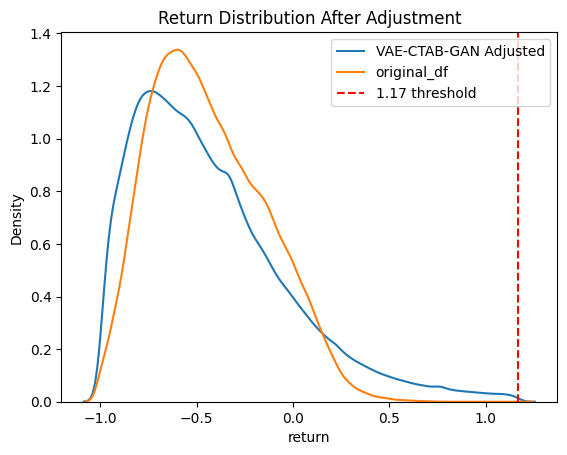

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

original_df['return'] = (original_df['total_pymnt_inv'] - original_df['funded_amnt']) / original_df['funded_amnt']

sns.kdeplot(vctabgan['return'], label='VAE-CTAB-GAN Adjusted')
sns.kdeplot(original_df['return'], label='original_df')
plt.axvline(threshold, color='r', linestyle='--', label='1.17 threshold')
plt.legend()
plt.title("Return Distribution After Adjustment")
plt.show()


In [14]:
vctabgan = vctabgan.drop(columns='return')

In [15]:
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/test_category.csv"
test_data = pd.read_csv(test_data_path)

fake = vctabgan.copy()

In [16]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [17]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [18]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (540000, 35)
✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [19]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [20]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [21]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68624	validation_1-logloss:0.68434
[1]	validation_0-logloss:0.67944	validation_1-logloss:0.67766
[2]	validation_0-logloss:0.67278	validation_1-logloss:0.67110
[3]	validation_0-logloss:0.66628	validation_1-logloss:0.66470
[4]	validation_0-logloss:0.65987	validation_1-logloss:0.65840
[5]	validation_0-logloss:0.65361	validation_1-logloss:0.65225
[6]	validation_0-logloss:0.64745	validation_1-logloss:0.64620
[7]	validation_0-logloss:0.64139	validation_1-logloss:0.64027
[8]	validation_0-logloss:0.63548	validation_1-logloss:0.63446
[9]	validation_0-logloss:0.62968	validation_1-logloss:0.62877
[10]	validation_0-logloss:0.62396	validation_1-logloss:0.62317
[11]	validation_0-logloss:0.61835	validation_1-logloss:0.61767
[12]	validation_0-logloss:0.61285	validation_1-logloss:0.61229
[13]	validation_0-logloss:0.60746	validation_1-logloss:0.60701
[14]	validation_0-logloss:0.60216	validation_1-logloss:0.60182
[15]	validation_0-logloss:0.59696	validation_1-logloss:0.59673
[1

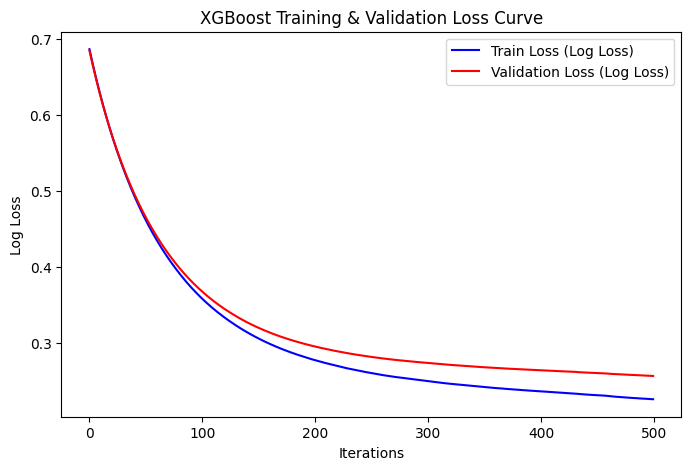

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    599114
           1       0.66      0.90      0.76    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.89      0.89    744306



In [23]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [24]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [25]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [36]:
#from sklearn.linear_model import HuberRegressor
#from xgboost import XGBRegressor
from scipy.stats import zscore

drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()
#reg = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3)
#reg = HuberRegressor()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()
fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total_reg = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total_reg = encode_features(train_total_reg, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x_reg = train_total_reg.drop(columns='return')
data_y_reg = train_total_reg[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_reg_scaled = scaler.fit_transform(data_x_reg)

X_train_reg = data_x_reg_scaled
y_train_reg = data_y_reg

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train_reg, y_train_reg)

#print(reg.coef_)
y_pred_reg = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred_reg, squared=False))
print("R²:", r2_score(test_y, y_pred_reg))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.1842984484473071
R²: -0.28897413834875096


In [38]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head(10)

,Average Return,Std Dev,Sharpe Ratio
0,16.193031,0.124491,1.300736
1,16.511908,0.127221,1.297890
2,16.191923,0.124495,1.300612
3,27.406616,0.192022,1.427262
4,15.287851,0.125540,1.217765
5,16.193031,0.124491,1.300736


In [25]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

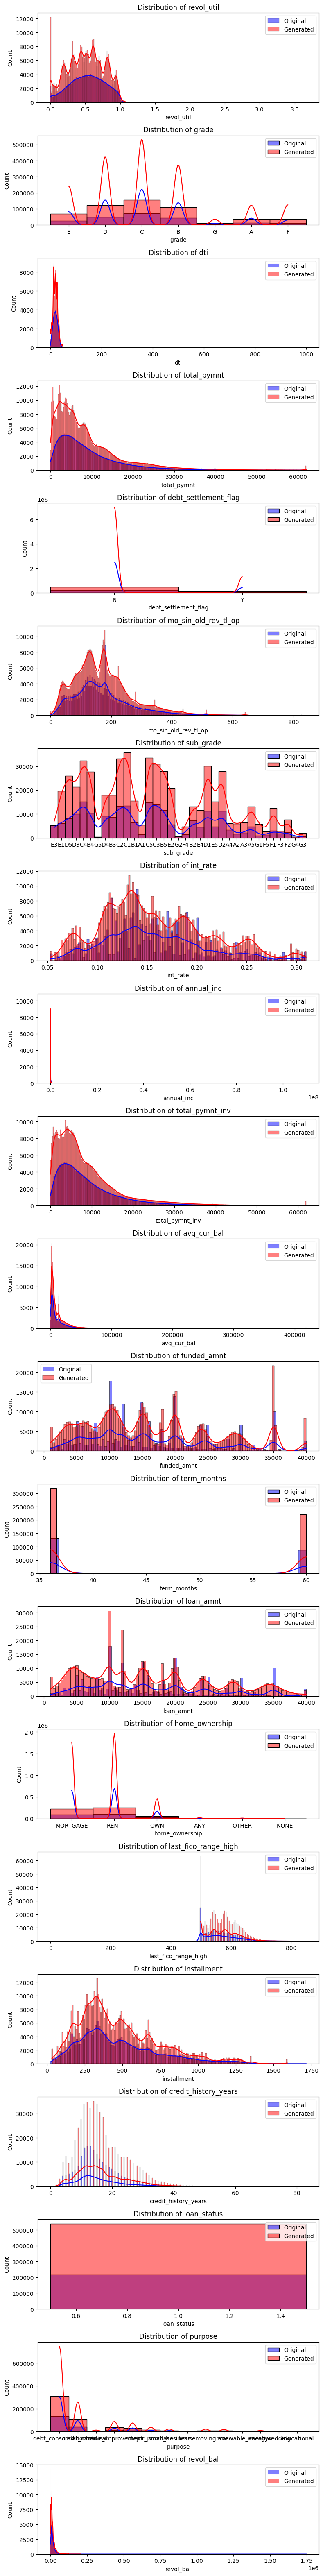

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(label1_data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()